In [1]:
#import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

In [2]:
#loading the datasets
train_data = pd.read_csv("train.csv")

In [3]:
#checking the datasets
print(f"The size of the traing dataset is{train_data.shape}")

The size of the traing dataset is(20800, 5)


In [4]:
train_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
#fill NULL values with empty string
train_data = train_data.fillna("")

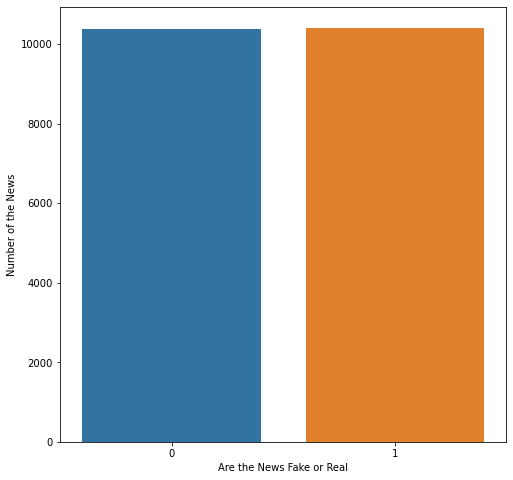

Real News (1) are 10413
Fake News (0) are 10387


In [6]:
# plot the number of samples in 'isfake'
plt.figure(figsize = (8, 8))
sns.countplot(x = "label", data = train_data)
plt.xlabel("Are the News Fake or Real")
plt.ylabel('Number of the News')
plt.show()
print(f"Real News (1) are {(train_data.label == 1).sum()}")
print(f"Fake News (0) are {(train_data.label == 0).sum()}")

In [7]:
X = train_data.drop("label", axis = 1)
y = train_data["label"]

print(X.shape)
print(y.shape)

(20800, 4)
(20800,)


In [8]:
#choosing vocabulary size to be 5000 and copying data to text for further cleaning
voc_size = 5000
text = X.copy()

In [9]:
#now its time to dowonload stopword and continue with data cleaning
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to C:\Users\Simeon
[nltk_data]     Velev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
#we will use stemming to map the words to their root forms 
ps = PorterStemmer()
corpus = []

In [11]:
#applying stemming and some preprocessing
for i in range(len(text)):
  review = re.sub('[^a-zA-Z]',' ',text['text'][i])
  review = review.lower()
  review = review.split()
  review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
  review = ' '.join(review)
  corpus.append(review)

In [12]:
#converting to one hot representation
onehot_rep = [one_hot(words,voc_size)for words in corpus]

In [41]:
#padding Sentences to make them of same size
embedded_docs = pad_sequences(onehot_rep,padding='pre', maxlen = 25)

In [42]:
tf.keras.backend.clear_session()

In [43]:
#creating our model
model = Sequential([
    Embedding(voc_size, 40, input_length = 25),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dropout(0.3),
    Dense(64, activation = "relu"),
    Dropout(0.2),
    Dense(32, activation = "relu"),
    Dropout(0.2),
    Dense(1, activation = "sigmoid"),
])

In [44]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 25, 40)            0         
                                                                 
 lstm (LSTM)                 (None, 25, 128)           86528     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [46]:
#converting into numpy array
#X_final = np.array(embedded_docs)
#y_final = np.array(y)
X_final,X_test,y_final,y_test = train_test_split(np.array(embedded_docs),np.array(y), test_size=0.2, random_state = 42)

X_final.shape,y_final.shape,X_test.shape, y_test.shape

((16640, 25), (16640,), (4160, 25), (4160,))

In [47]:
#training our model
history = model.fit(X_final,y_final,epochs=10,batch_size=64, validation_data=[X_test, y_test])

Epoch 1/10
260/260 [==============================] - 29s 95ms/step - loss: 0.4113 - accuracy: 0.8041 - val_loss: 0.3114 - val_accuracy: 0.8603
Epoch 2/10
260/260 [==============================] - 24s 92ms/step - loss: 0.2500 - accuracy: 0.8963 - val_loss: 0.3044 - val_accuracy: 0.8666
Epoch 3/10
260/260 [==============================] - 23s 90ms/step - loss: 0.1994 - accuracy: 0.9236 - val_loss: 0.3347 - val_accuracy: 0.8642
Epoch 4/10
260/260 [==============================] - 22s 83ms/step - loss: 0.1545 - accuracy: 0.9406 - val_loss: 0.3441 - val_accuracy: 0.8671
Epoch 5/10
260/260 [==============================] - 24s 91ms/step - loss: 0.1186 - accuracy: 0.9571 - val_loss: 0.4181 - val_accuracy: 0.8620
Epoch 6/10
260/260 [==============================] - 21s 83ms/step - loss: 0.0896 - accuracy: 0.9677 - val_loss: 0.5734 - val_accuracy: 0.8529
Epoch 7/10
260/260 [==============================] - 23s 88ms/step - loss: 0.0681 - accuracy: 0.9752 - val_loss: 0.5456 - val_accuracy:

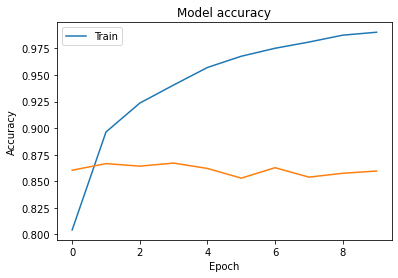

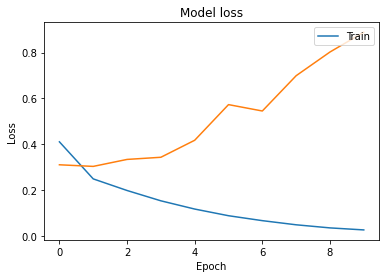

In [48]:
# Visualize the results:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [ ]:
# making predictions
#predictions = model.predict(test_final)
#predictions = [int(np.round(pred[0])) for pred in predictions]